# 데이터 불러오기

In [11]:
import glob
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)


txt_list = glob.glob(txt_file_path)
raw_corpus = []

for x in txt_list:
    with open(x, 'r') as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


# 데이터 정제

In [12]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [13]:
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

In [14]:
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

In [15]:
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)

    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   

    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   2  735    5 ...    0    0    0]
 [   2  735    5 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f7c765c3880>


In [16]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [17]:
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]   

# 평가 데이터셋 분리

In [19]:
from sklearn.model_selection import train_test_split

# train/validation/test set으로 분할
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)
enc_val, enc_test, dec_val, dec_test = train_test_split(enc_val, dec_val, test_size=0.5, random_state=42)

In [20]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1  

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(len(enc_train)).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder = True)

test_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder = True)

# Modeling

In [26]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
#         self.dropout = tf.keras.layers.Dropout(0.5)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
#         out = self.dropout(out)
        out = self.rnn_2(out)
#         out = self.dropout(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 
hidden_size = 1024 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [30]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
model.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
549/549 [==============================] - 111s 191ms/step - loss: 2.8318 - val_loss: 2.5178
Epoch 2/30
549/549 [==============================] - 105s 192ms/step - loss: 2.4307 - val_loss: 2.3636
Epoch 3/30
549/549 [==============================] - 105s 192ms/step - loss: 2.3031 - val_loss: 2.2742
Epoch 4/30
549/549 [==============================] - 105s 192ms/step - loss: 2.2113 - val_loss: 2.2089
Epoch 5/30
549/549 [==============================] - 105s 192ms/step - loss: 2.1342 - val_loss: 2.1573
Epoch 6/30
549/549 [==============================] - 105s 192ms/step - loss: 2.0651 - val_loss: 2.1141
Epoch 7/30
549/549 [==============================] - 105s 192ms/step - loss: 2.0015 - val_loss: 2.0775
Epoch 8/30
549/549 [==============================] - 105s 192ms/step - loss: 1.9418 - val_loss: 2.0466
Epoch 9/30
549/549 [==============================] - 105s 192ms/step - loss: 1.8853 - val_loss: 2.0202
Epoch 10/30
549/549 [==============================] - 105s 192m

In [34]:
# 테스트 데이터셋에 대해 모델 실행 및 평가
test_loss = model.evaluate(test_dataset)

# 모델의 성능 출력
print(f'Test Loss: {test_loss:.2f}')

68/68 [==============================] - 5s 68ms/step - loss: 1.9102
Test Loss: 1.91


# Generate

In [35]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [36]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you <end> '

# overfitting 해결

In [43]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True, activity_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True, activity_regularizer=tf.keras.regularizers.l2(0.01))
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.dropout(out)
        out = self.rnn_2(out)
        out = self.dropout(out)
        out = self.linear(out)
        
        return out

embedding_size = 512
hidden_size = 1024 
model2 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [44]:
optimizer = tf.keras.optimizers.Adam(clipvalue=1.0) # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model2.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
history=model2.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
549/549 [==============================] - 119s 209ms/step - loss: 2.8233 - accuracy: 0.5708 - val_loss: 2.4923 - val_accuracy: 0.5963
Epoch 2/30
549/549 [==============================] - 115s 209ms/step - loss: 2.4311 - accuracy: 0.6025 - val_loss: 2.3288 - val_accuracy: 0.6104
Epoch 3/30
549/549 [==============================] - 114s 208ms/step - loss: 2.3070 - accuracy: 0.6116 - val_loss: 2.2361 - val_accuracy: 0.6172
Epoch 4/30
549/549 [==============================] - 114s 208ms/step - loss: 2.2216 - accuracy: 0.6175 - val_loss: 2.1675 - val_accuracy: 0.6237
Epoch 5/30
549/549 [==============================] - 115s 209ms/step - loss: 2.1532 - accuracy: 0.6227 - val_loss: 2.1181 - val_accuracy: 0.6279
Epoch 6/30
549/549 [==============================] - 115s 210ms/step - loss: 2.0941 - accuracy: 0.6275 - val_loss: 2.0717 - val_accuracy: 0.6337
Epoch 7/30
549/549 [==============================] - 115s 210ms/step - loss: 2.0425 - accuracy: 0.6319 - val_loss: 2.0365 -

In [61]:
import matplotlib.pyplot as plt
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

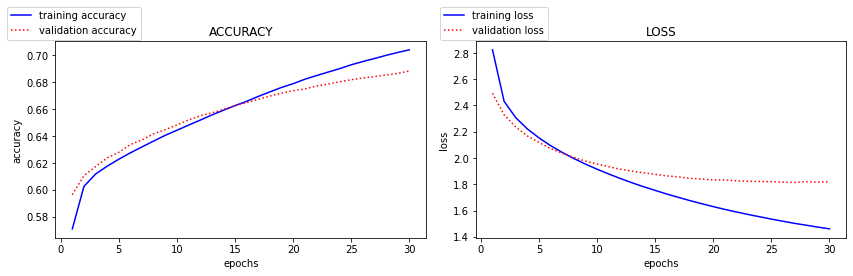

In [62]:
plot_history(history)

In [56]:
# 테스트 데이터셋에 대해 모델 실행 및 평가
test_loss, test_accuracy = model2.evaluate(test_dataset)
print('Test_loss : {:.2f}, Test accuracy : {:2f}'.format(test_loss, test_accuracy))

68/68 [==============================] - 5s 79ms/step - loss: 1.8213 - accuracy: 0.6887
Test_loss : 1.82, Test accuracy : 0.688724


첫 실험보다 test loss가 조금 줄었지만 dropout(0.5) 추가만으로는 overfitting을 막지 못했다.